In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, desc, col, round
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

In [2]:
spark = SparkSession.builder \
    .appName("Análisis de eventos de comercio electrónico") \
    .getOrCreate()


23/06/22 11:21:39 WARN Utils: Your hostname, MacBook-Air-de-Gonzalo.local resolves to a loopback address: 127.0.0.1; using 192.168.0.11 instead (on interface en0)
23/06/22 11:21:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/22 11:21:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
#octubre
df1 = spark.read.format("csv").option("header", "true").load("/Users/gonzaloperezreich/Desktop/Proyecto apache/2019-Oct.csv")
#noviembre
df2 = spark.read.format("csv").option("header", "true").load("/Users/gonzaloperezreich/Desktop/Proyecto apache/2019-Nov.csv")
#diciembre
df3 = spark.read.format("csv").option("header", "true").load("/Users/gonzaloperezreich/Desktop/Proyecto apache/2019-Dec.csv")
#enero
df4= spark.read.format("csv").option("header", "true").load("/Users/gonzaloperezreich/Desktop/Proyecto apache/2020-Jan.csv")
#febrero
df5 = spark.read.format("csv").option("header", "true").load("/Users/gonzaloperezreich/Desktop/Proyecto apache/2020-Feb.csv")


# Data discovery 

## Monthly and Totally Data:

Almost 21 million of transactions recorded in 5 months

In [4]:
octubre= df1.count()
noviembre= df2.count()
diciembre= df3.count()
enero= df4.count()
febrero= df5.count()

In [5]:
print("por orden (octubre,noviembre,diciembre,enero,febrero): ",octubre,noviembre,diciembre,enero,febrero)
print("total: "+ str(octubre+noviembre+diciembre+enero+febrero))

por orden (octubre,noviembre,diciembre,enero,febrero):  4102283 4635837 3533286 4264752 4156682
total: 20692840


## Unique users per month
January registers the greatest amount of individual users. Also we can see a little drop down in the quatity of users in november and december in comparison with october

In [6]:
unique_users = df1.select('user_id').distinct().count()
unique_users1 = df2.select('user_id').distinct().count()
unique_users2 = df3.select('user_id').distinct().count()
unique_users3 = df4.select('user_id').distinct().count()
unique_users4= df5.select('user_id').distinct().count()

399664 368232 370154 410073 391055


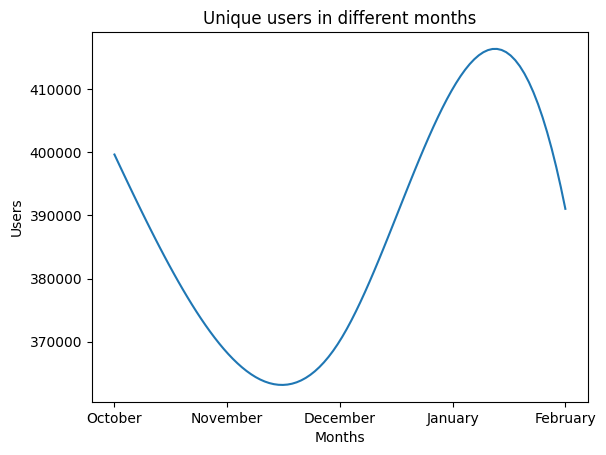

In [7]:
print(unique_users,unique_users1,unique_users2,unique_users3, unique_users4)
users=np.array([unique_users,unique_users1,unique_users2,unique_users3, unique_users4])
months=np.array(["October", "November", "December","January", "February"])
# Crear una función de interpolación
f = interp1d(np.arange(len(months)), users, kind='cubic')

x_interp = np.linspace(0, len(months) - 1, 100)
users_interp = f(x_interp)

plt.plot(x_interp, users_interp)
plt.xlabel("Months")
plt.ylabel("Users")
plt.title("Unique users in different months")
plt.xticks(np.arange(len(months)), months)  # Establecer las marcas en el eje x
plt.show()

## Average activity for users:
We can see that the average activity changes in November and December, Why does that happen?

In [8]:
events_octubre = octubre / unique_users
events_nov = noviembre / unique_users1
events_dic = diciembre / unique_users2
events_en = enero / unique_users3
events_feb = febrero / unique_users4
print(events_octubre, events_nov, events_dic,events_en,events_feb)

10.264329536810921 12.589446327315388 9.545448651101974 10.399982442150543 10.629405070897956


The average activity does not mean that those months are really the ones with the highest sales.
This is because the activity is monitored in 3 cases (purchase, cart, remove from cart), so it can be a month with a lot of activity but it can be the month with the lowest incomes.

Let´s figure which month has the greatest sales:

In [9]:
sales_oct = df1.filter(col('event_type') == 'purchase')
total_sales_oct = sales_oct.count()

sales_nov = df2.filter(col('event_type') == 'purchase')
total_sales_nov = sales_nov.count()

sales_dec = df3.filter(col('event_type') == 'purchase')
total_sales_dec = sales_dec.count()

sales_jan = df4.filter(col('event_type') == 'purchase')
total_sales_jan = sales_jan.count()

sales_feb = df5.filter(col('event_type') == 'purchase')
total_sales_feb = sales_feb.count()
# Mostrar el resultado
print("Total de sales octubre:", total_sales_oct)
print("Total de sales nov:", total_sales_nov)
print("Total de sales dic:", total_sales_dec)
print("Total de sales en:", total_sales_jan)
print("Total de sales feb:", total_sales_feb)


Total de sales octubre: 245624
Total de sales nov: 322417
Total de sales dic: 213176
Total de sales en: 263797
Total de sales feb: 241993


Supricely the month with the lowest sales it´s december even when Christmas and New year are the main events that month.
Nevertheless November records the most sales, this could be suspected but ¿why and when? ¿Does the prices lower in november? ¿it´s black friday the main event for sales in november? Let´s find out:

### Black friday (24/11/year):
Only 6% of the november sales are made on november 24.

In [10]:
sales_24_nov = df2.filter((col('event_type') == 'purchase') & (col('event_time').contains('2019-11-24')))
total_sales_24_nov = sales_24_nov.count()

# Mostrar el resultado
print("Total de compras el 24 de noviembre:", total_sales_24_nov)
print("porcentaje de ventas= ", str((total_sales_24_nov/322417) *100)+"%")

Total de compras el 24 de noviembre: 20464
porcentaje de ventas=  6.347059863468737%


### Prices
There are few ways to study this variable, here we are going to do in two ways:
One it´s to summarize the total price of items and divide it for the quantity of items per month.
Another one its to compare the price of popular items in diferent dates wondering to expect lower prices in the month of november in comparison with december and octuber.


#### Summatory / Quantity

In [34]:
#October
distinct_oct = df1.select("product_id", "price").distinct()
summ_oct = distinct_oct.agg(sum("price")).collect()[0][0]
x=distinct_oct.count()
print("Summ oct:", summ_oct)
print("quantity:",x)
print("division:",summ_oct/x)

#November
distinct_nov = df2.select("product_id", "price").distinct()
summ_nov = distinct_nov.agg(sum("price")).collect()[0][0]
y=distinct_nov.count()
print("Summ nov:", summ_nov)
print("quantity:",y)
print("division:",summ_nov/y)


#December
distinct_dec = df3.select("product_id", "price").distinct()
summ_dec = distinct_dec.agg(sum("price")).collect()[0][0]
z=distinct_dec.count()
print("Summ dec:", summ_dec)
print("quantity:",z)
print("division:",summ_dec/z)


#January
distinct_jan = df4.select("product_id", "price").distinct()
summ_jan = distinct_jan.agg(sum("price")).collect()[0][0]
w=distinct_jan.count()
print("Summ jan:", summ_jan)
print("quantity:",w)
print("division:",summ_jan/w)

#February
distinct_feb = df5.select("product_id", "price").distinct()
summ_feb = distinct_feb.agg(sum("price")).collect()[0][0]
a=distinct_feb.count()
print("Summ feb:", summ_feb)
print("quantity:",a)
print("division:",summ_feb/a)

Summ oct: 337514.72999999695
quantity: 45026
division: 7.495996313241171


Summ nov: 569835.5400000056
quantity: 83274
division: 6.842898623820227


Summ dec: 380274.49999999616
quantity: 50870
division: 7.475417731472305


Summ jan: 379835.59999999346
quantity: 48912
division: 7.765693490349882


Summ feb: 423588.77999998746
quantity: 70248
division: 6.029905193030228


23/06/22 19:07:24 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 7525971 ms exceeds timeout 120000 ms
23/06/22 19:07:24 WARN SparkContext: Killing executors is not supported by current scheduler.
23/06/22 19:07:25 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.

November and February with this metric are the cheapest months for buying in the eCommerce, ofCourse this is not a significant metric, because it can be a lot of cheapest articles and a few really expensive, Nonetheless we coud observe that November is  the month with the hugest inventary almost doubling the inventory of the previous and the following months.
Also it would be interesting to discover if exists differecences between prices of the same articles in the diferent moths. This is why the following section will try to respond that question


#### Differences between months

For this we want to compare which items are the same in the diferent months and compare de prices summing de diference between the prices. 
if de difference is diferent to cero the prices are higher than the other month. 
For simplicity we would compare every month with november, because we have the hypothesis that november is the cheapest month for buying things in the eCommerce 

## Productos populares

In [40]:
popular_products = df1.groupBy('product_id').count().orderBy('count', ascending=False)

In [45]:
# Calcular la cantidad de ventas por producto
sales_stats = df1.filter(df1.event_type == 'purchase') \
                .groupBy('product_id') \
                .agg(round(sum(col('price'))).alias('total_sales')) \
                .orderBy(desc('total_sales'))

# Calcular la cantidad de veces que se agregaron al carrito por producto
add_to_cart_stats = df1.filter(df1.event_type == 'cart') \
                      .groupBy('product_id') \
                      .count() \
                      .orderBy(desc('count'))

# Calcular la cantidad de veces que se sacaron del carrito por producto
remove_from_cart_stats = df1.filter(df1.event_type == 'remove_from_cart') \
                           .groupBy('product_id') \
                           .count() \
                           .orderBy(desc('count'))

# Mostrar las estadísticas de ventas
sales_stats.show()

# Mostrar las estadísticas de agregados al carrito
add_to_cart_stats.show()

# Mostrar las estadísticas de sacados del carrito
remove_from_cart_stats.show()

+----------+-----------+
|product_id|total_sales|
+----------+-----------+
|   5877454|    11117.0|
|   5560754|     8555.0|
|   5560756|     7694.0|
|   5856186|     7088.0|
|   5751422|     7052.0|
|   5846437|     6288.0|
|   5792800|     6109.0|
|   5751383|     5841.0|
|   5855507|     5782.0|
|   5849033|     4541.0|
|     89343|     4497.0|
|   5861276|     3996.0|
|   5528035|     3818.0|
|   5892179|     3816.0|
|   5882788|     3594.0|
|   5795346|     3523.0|
|   5692527|     3451.0|
|   5804820|     3420.0|
|   5866964|     3406.0|
|   5560758|     3371.0|
+----------+-----------+
only showing top 20 rows



+----------+-----+
|product_id|count|
+----------+-----+
|   5700037| 4998|
|   5802432| 4693|
|   5686925| 4356|
|   5854897| 3966|
|   5700046| 2897|
|   5815662| 2830|
|   5688124| 2745|
|   5836522| 2470|
|   5751422| 2251|
|   5751383| 2068|
|   5792800| 1965|
|      5304| 1959|
|   5700035| 1890|
|   5849033| 1652|
|   5809911| 1597|
|   5843836| 1584|
|   5809912| 1580|
|      5581| 1454|
|   5528035| 1438|
|   5565820| 1396|
+----------+-----+
only showing top 20 rows



+----------+-----+
|product_id|count|
+----------+-----+
|   5700037| 1412|
|   5751422| 1219|
|   5686925| 1191|
|   5854897| 1175|
|   5751383| 1158|
|   5802432| 1156|
|   5815662| 1077|
|   5809912| 1060|
|   5792800| 1054|
|   5809911|  950|
|   5773361|  801|
|   5773605|  773|
|   5819112|  768|
|   5820746|  739|
|      5304|  732|
|   5528035|  726|
|   5849033|  718|
|   5816170|  711|
|      5013|  673|
|   5833334|  649|
+----------+-----+
only showing top 20 rows



La gente compra mas productos en noviembre que en diciembre, se tiene a hipotesis que existe anticipacion de la navidad, sumado a ello el black friday es el 24 de noviembre. así que veremos si la mayoria de las ventas de noviembre se llevan a cabo en ese periodo de tiempo 

In [59]:

# Filtrar los registros de compras
compras = df2.filter(col('event_type') == 'purchase')

# Contar la cantidad de ventas por fecha
ventas_por_fecha = compras.groupBy('event_time').count().orderBy(col('count').desc())

# Obtener la fecha con la mayor cantidad de ventas
fecha_max_ventas = ventas_por_fecha.select('event_time').first()[0]

# Mostrar el resultado
print("Fecha con mayor cantidad de ventas:", fecha_max_ventas)



Fecha con mayor cantidad de ventas: 2019-11-18 01:17:08 UTC
